In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import filters, morphology, color
from skimage.segmentation import slic


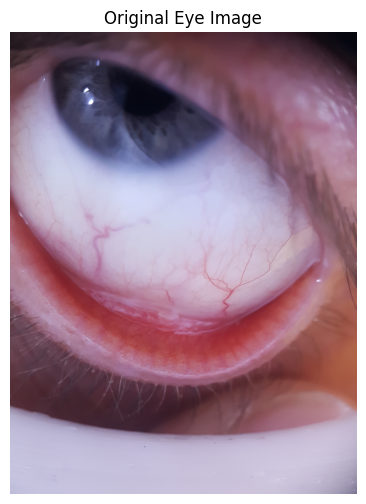

In [21]:
# Load the sample eye image (replace 'eye_image.jpg' with your actual file path)
image_path = 'img3.jpg'  # Update with the actual path to your dataset image
eye_image = cv2.imread(image_path)

# Convert BGR image to RGB for visualization
eye_image_rgb = cv2.cvtColor(eye_image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(eye_image_rgb)
plt.title("Original Eye Image")
plt.axis("off")
plt.show()


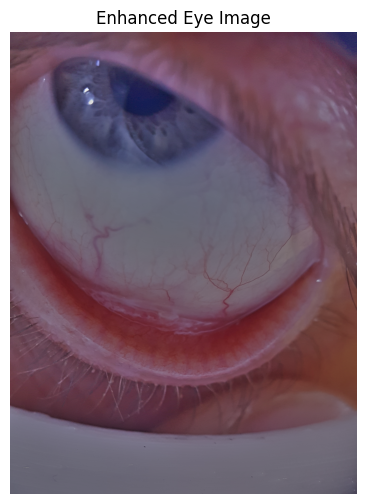

In [22]:
def msrcr(image, sigma_list):
    """
    Apply Multi-Scale Retinex with Color Restoration (MSRCR).
    """
    # Convert to HSV to work on the intensity channel
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float32)
    intensity = hsv[:, :, 2] / 255.0

    retinex = np.zeros_like(intensity)
    for sigma in sigma_list:
        gaussian = cv2.GaussianBlur(intensity, (0, 0), sigma)
        log_image = np.log1p(intensity) - np.log1p(gaussian)
        retinex += log_image

    retinex /= len(sigma_list)
    retinex = (retinex - np.min(retinex)) / (np.max(retinex) - np.min(retinex))

    # Restore color
    hsv[:, :, 2] = retinex * 255
    enhanced_image = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
    return enhanced_image

# Apply MSRCR
sigma_list = [15, 80, 250]  # Multi-scale sigma values
enhanced_image = msrcr(eye_image_rgb, sigma_list)

# Display the enhanced image
plt.figure(figsize=(6, 6))
plt.imshow(enhanced_image)
plt.title("Enhanced Eye Image")
plt.axis("off")
plt.show()


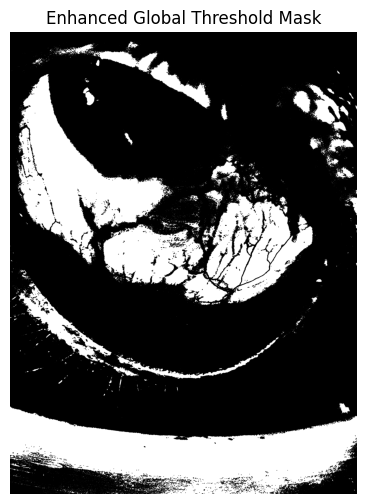

In [23]:
def enhanced_global_threshold(image):
    """
    Enhanced global thresholding with dynamic adjustment based on intensity analysis.
    """
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Compute histogram to analyze intensity distribution
    hist, bin_edges = np.histogram(gray_image, bins=256, range=(0, 256))

    # Select an initial threshold based on histogram peaks
    initial_threshold = np.argmax(hist)

    # Apply a global threshold using the initial value
    _, binary_mask = cv2.threshold(gray_image, initial_threshold, 255, cv2.THRESH_BINARY)

    # Use morphology to clean the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    refined_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    # Dynamically adjust the threshold to refine the mask
    dynamic_threshold = initial_threshold
    while True:
        # Recompute mask
        _, dynamic_mask = cv2.threshold(gray_image, dynamic_threshold, 255, cv2.THRESH_BINARY)

        # Clean the mask
        dynamic_mask = cv2.morphologyEx(dynamic_mask, cv2.MORPH_CLOSE, kernel)

        # Check mask coverage (e.g., sclera typically covers 5-50% of the image)
        coverage = np.sum(dynamic_mask) / (dynamic_mask.shape[0] * dynamic_mask.shape[1])
        if 0.05 <= coverage <= 0.5:
            refined_mask = dynamic_mask
            break

        # Dynamically adjust threshold
        dynamic_threshold -= 5  # Reduce threshold incrementally
        if dynamic_threshold < 10:  # Stop if too low
            break

    return refined_mask

# Apply the enhanced global threshold
final_global_mask = enhanced_global_threshold(enhanced_image)

# Display the final global threshold mask
plt.figure(figsize=(6, 6))
plt.imshow(final_global_mask, cmap="gray")
plt.title("Enhanced Global Threshold Mask")
plt.axis("off")
plt.show()


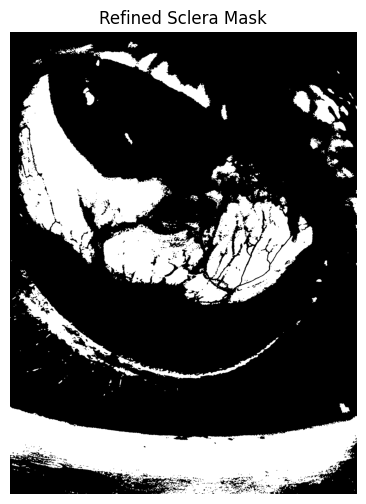

In [24]:
def refine_mask(binary_mask):
    """
    Refine the binary mask using morphological operations.
    """
    # Apply morphological closing to fill small gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    closed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    # Apply morphological opening to remove noise
    refined_mask = cv2.morphologyEx(closed_mask, cv2.MORPH_OPEN, kernel)

    return refined_mask

# Refine the sclera mask
refined_sclera_mask = refine_mask(final_global_mask)

# Display the refined mask
plt.figure(figsize=(6, 6))
plt.imshow(refined_sclera_mask, cmap="gray")
plt.title("Refined Sclera Mask")
plt.axis("off")
plt.show()


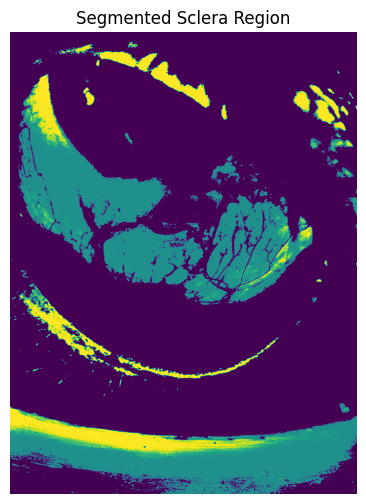

In [25]:
def kmeans_segmentation(image, refined_mask, n_clusters=3):
    """
    Apply K-Means clustering for image segmentation.
    """
    # Mask the image to focus on the refined sclera region
    masked_image = cv2.bitwise_and(image, image, mask=refined_mask)

    # Reshape the image into a 2D array of pixels
    pixel_values = masked_image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    labels = kmeans.fit_predict(pixel_values)

    # Reshape labels to match the image dimensions
    segmented_image = labels.reshape((image.shape[:2]))

    return segmented_image

# Apply K-Means clustering
segmented_sclera = kmeans_segmentation(enhanced_image, refined_sclera_mask)

# Display the clustered segmentation
plt.figure(figsize=(6, 6))
plt.imshow(segmented_sclera, cmap="viridis")
plt.title("Segmented Sclera Region")
plt.axis("off")
plt.show()


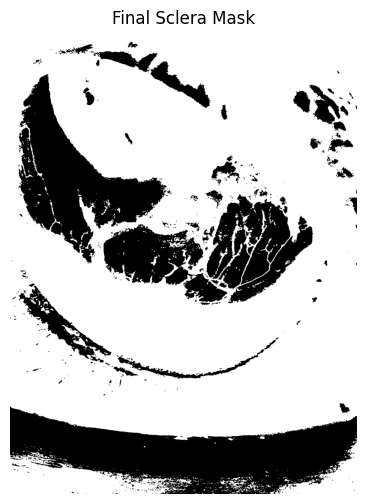

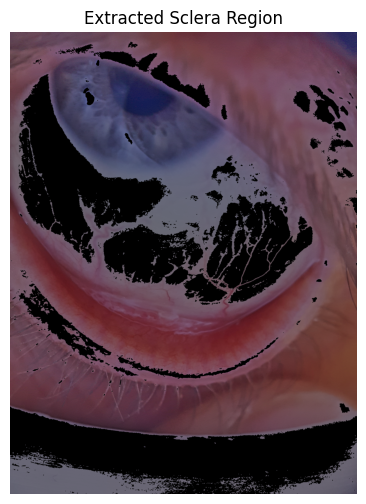

In [26]:
def extract_sclera_cluster(segmented_image, image, cluster_id):
    """
    Extract the cluster corresponding to the sclera and refine the mask.
    """
    # Create a binary mask for the sclera cluster
    sclera_cluster_mask = np.where(segmented_image == cluster_id, 255, 0).astype(np.uint8)

    # Apply the mask to the original image
    sclera_region = cv2.bitwise_and(image, image, mask=sclera_cluster_mask)

    return sclera_cluster_mask, sclera_region

# Assuming the brightest cluster corresponds to the sclera
# You can verify this by inspecting the clusters manually
brightest_cluster_id = np.argmax(np.bincount(segmented_sclera.flatten()))

# Extract the sclera cluster
sclera_cluster_mask, sclera_region = extract_sclera_cluster(segmented_sclera, enhanced_image, brightest_cluster_id)

# Display the extracted sclera mask
plt.figure(figsize=(6, 6))
plt.imshow(sclera_cluster_mask, cmap="gray")
plt.title("Final Sclera Mask")
plt.axis("off")
plt.show()

# Display the extracted sclera region
plt.figure(figsize=(6, 6))
plt.imshow(sclera_region)
plt.title("Extracted Sclera Region")
plt.axis("off")
plt.show()
